In [1]:
from argparse import Namespace
import collections
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import torch

In [2]:
# Set Numpy and PyTorch seeds
def set_seeds(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

In [3]:
# Arguments
args = Namespace(
    seed=1234,
    cuda=False,
    shuffle=True,
    data_file="tumors.csv",
    reduced_data_file="tumors_reduced.csv",
    train_size=0.75,
    test_size=0.25,
    num_hidden_units=100,
    learning_rate=1e-3,
    num_epochs=100,
)

# Check CUDA
if torch.cuda.is_available():
    args.cuda = True
args.device = torch.device("cuda" if args.cuda else "cpu")
print("Using CUDA: {}".format(args.cuda))

# Set seeds
set_seeds(seed=args.seed, cuda=args.cuda)

Using CUDA: True


# Data

In [4]:
import re
import urllib

In [5]:
# Upload data from Github to notebook's local drive
url = "https://raw.githubusercontent.com/GokuMohandas/practicalAI/master/data/tumors.csv"
response = urllib.request.urlopen(url)
html = response.read()
with open(args.data_file, 'wb') as fp:
    fp.write(html)

In [6]:
# Raw data
df = pd.read_csv(args.data_file, header=0)
df.head()

,leukocyte_count,blood_pressure,tumor
0,13.472969,15.250393,1
1,10.805510,14.109676,1
2,13.834053,15.793920,1
3,9.572811,17.873286,1
4,7.633667,16.598559,1


In [7]:
def plot_tumors(df):
    i = 0
    colors = ['r', 'b']
    for name, group in df.groupby('tumor'):
        plt.scatter(group.leukocyte_count, group.blood_pressure, edgecolors='k',
                    color=colors[i])
        i += 1
    plt.xlabel('leukocyte count')
    plt.ylabel('blood pressure')
    plt.legend(['0 - begin', '1 - malignant'], loc='upper right')
    plt.show()

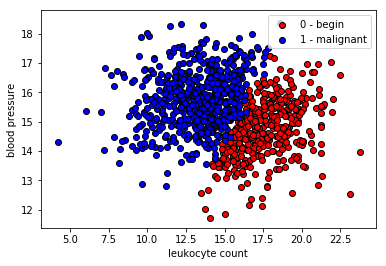

In [8]:
# Plot data
plot_tumors(df)

In [9]:
# Convert to PyTorch tensors
X = df.as_matrix(columns=['leukocyte_count', 'blood_pressure'])
y = df.as_matrix(columns=['tumor'])
X = torch.from_numpy(X).float()
y = torch.from_numpy(y.ravel()).long()

/home/texuanw/apps/anaconda3/envs/python/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/texuanw/apps/anaconda3/envs/python/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [10]:
# Shuffle data
shuffle_indices = torch.LongTensor(random.sample(range(0, len(X)), len(X)))
X = X[shuffle_indices]
y = y[shuffle_indices]

# Split datasets
test_start_idx = int(len(X) * args.train_size)
X_train = X[:test_start_idx]
y_train = y[:test_start_idx]
X_test = X[test_start_idx:]
y_test = y[test_start_idx:]
print("We have %i train samples and %i test samples." % (len(X_train), len(X_test)))

We have 750 train samples and 250 test samples.


# Model

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [12]:
# Multilayer Perception
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x_in, apply_softmax=False):
        a_1 = F.relu(self.fc1(x_in))
        y_pred = self.fc2(a_1)
        
        if apply_softmax:
            y_pred = F.softmax(y_pred, dim=1)
        
        return y_pred

In [13]:
# Initialize model
model = MLP(input_dim=len(df.columns)-1,
            hidden_dim=args.num_hidden_units,
            output_dim=len(set(df.tumor)))

In [14]:
# Optimization
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)

In [15]:
# Accuracy
def get_accuracy(y_pred, y_target):
    n_correct = torch.eq(y_pred, y_target).sum().item()
    accuracy = n_correct / len(y_pred) * 100
    return accuracy

In [16]:
# Training
for t in range(args.num_epochs):
    # Forward pass
    y_pred = model(X_train)
    
    # Accuracy
    _, predictions = y_pred.max(dim=1)
    accuracy = get_accuracy(y_pred=predictions.long(), y_target=y_train)
    
    # Loss
    loss = loss_fn(y_pred, y_train)
    
    # Verbose
    if t%20 == 0:
        print("epoch {:02d} | loss: {:.4f} | accuracy: {:.1f}%".format(
            t, loss, accuracy))
    
    # Zero all gradients
    optimizer.zero_grad()
    
    # Backward pass
    loss.backward()
    
    # Update weights
    optimizer.step()

epoch 00 | loss: 4.4696 | accuracy: 39.7%
epoch 20 | loss: 0.8994 | accuracy: 60.3%
epoch 40 | loss: 0.3765 | accuracy: 95.7%
epoch 60 | loss: 0.2728 | accuracy: 98.0%
epoch 80 | loss: 0.1748 | accuracy: 98.4%


In [17]:
# Predictions
_, pred_train = model(X_train, apply_softmax=True).max(dim=1)
_, pred_test = model(X_test, apply_softmax=True).max(dim=1)

In [18]:
# Train and test accuracy
train_acc = get_accuracy(y_pred=pred_train, y_target=y_train)
test_acc = get_accuracy(y_pred=pred_test, y_target=y_test)
print("train acc: {:.1f}%, test acc: {:.1f}%".format(train_acc, test_acc))

train acc: 98.9%, test acc: 98.8%


In [19]:
# Visualization
def plot_multiclass_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))
    cmap = plt.cm.Spectral
    
    X_test = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()
    y_pred = model(X_test, apply_softmax=True)
    _, y_pred = y_pred.max(dim=1)
    y_pred = y_pred.reshape(xx.shape)
    
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

We're going to plot a white point, which we know belongs to the malignant tumor class. Our well trained model here would accurately predict that it is indeed a malignant tumor!

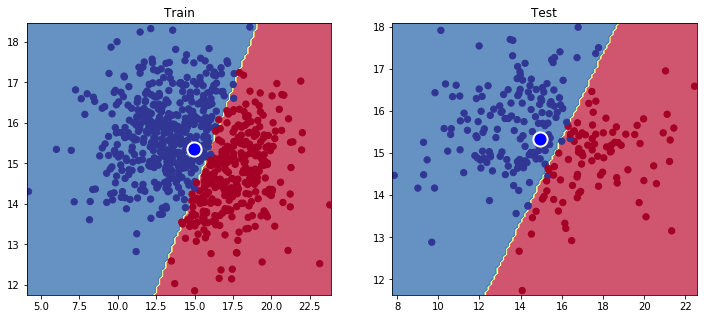

In [20]:
# Visualize the decision boundary
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.title('Train')
plot_multiclass_decision_boundary(model=model, X=X_train, y=y_train)
plt.scatter(np.mean(df.leukocyte_count), np.mean(df.blood_pressure), s=200,
            c='b', edgecolor='w', linewidths=2)
plt.subplot(1,2,2)
plt.title('Test')
plot_multiclass_decision_boundary(model=model, X=X_test, y=y_test)
plt.scatter(np.mean(df.leukocyte_count), np.mean(df.blood_pressure), s=200,
            c='b', edgecolors='w', linewidths=2)
plt.show()

# Data Quality and Quantity
Let's remove some training data near the decision boundary and see how robust the model is now.

In [21]:
url = "https://raw.githubusercontent.com/GokuMohandas/practicalAI/master/data/tumors_reduced.csv"
response = urllib.request.urlopen(url)
html = response.read()
with open(args.reduced_data_file, 'wb') as fp:
    fp.write(html)

In [22]:
# Raw reduced data
df_reduced = pd.read_csv(args.reduced_data_file, header=0)
df_reduced.head()

,leukocyte_count,blood_pressure,tumor
0,13.472969,15.250393,1
1,10.805510,14.109676,1
2,13.834053,15.793920,1
3,9.572811,17.873286,1
4,7.633667,16.598559,1


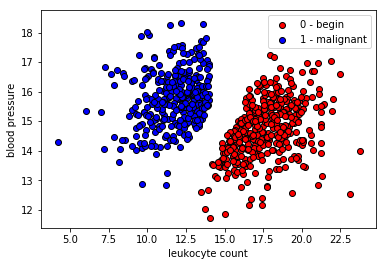

In [23]:
# Plot data
plot_tumors(df_reduced)

In [24]:
# Convert to PyTorch tensors
X = df_reduced.as_matrix(columns=['leukocyte_count', 'blood_pressure'])
y = df_reduced.as_matrix(columns=['tumor'])
X = torch.from_numpy(X).float()
y = torch.from_numpy(y.ravel()).long()

/home/texuanw/apps/anaconda3/envs/python/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/texuanw/apps/anaconda3/envs/python/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [25]:
# Shuffle data
shuffle_indices = torch.LongTensor(random.sample(range(0, len(X)), len(X)))
X = X[shuffle_indices]
y = y[shuffle_indices]

# Split datasets
test_start_idx = int(len(X) * args.train_size)
X_train = X[:test_start_idx]
y_train = y[:test_start_idx]
X_test = X[test_start_idx:]
y_test = y[test_start_idx:]
print("We have %i train samples and %i test samples." % (len(X_train), len(X_test)))

We have 540 train samples and 180 test samples.


In [26]:
# Initialize model
model = MLP(input_dim=len(df_reduced.columns)-1,
            hidden_dim=args.num_hidden_units,
            output_dim=len(set(df_reduced.tumor)))

In [27]:
# Optimization
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)

In [28]:
# Training
for t in range(args.num_epochs):
    # Forward pass
    y_pred = model(X_train)
    
    # Accuracy
    _, predictions = y_pred.max(dim=1)
    accuracy = get_accuracy(y_pred=predictions.long(), y_target=y_train)
    
    # Loss
    loss = loss_fn(y_pred, y_train)
    
    # Verbose
    if t%20 == 0:
        print("epoch: {} | loss: {:.4f} | accuracy: {:.1f}%".format(t, loss, accuracy))
        
    # Zero all gradients
    optimizer.zero_grad()
    
    # Backward pass
    loss.backward()
    
    # Update weights
    optimizer.step()

epoch: 0 | loss: 0.9123 | accuracy: 53.5%
epoch: 20 | loss: 0.2822 | accuracy: 100.0%
epoch: 40 | loss: 0.1311 | accuracy: 100.0%
epoch: 60 | loss: 0.0744 | accuracy: 100.0%
epoch: 80 | loss: 0.0506 | accuracy: 100.0%


In [29]:
# Predictions
_, pred_train = model(X_train, apply_softmax=True).max(dim=1)
_, pred_test = model(X_test, apply_softmax=True).max(dim=1)

In [30]:
# Train and test accuracy
train_acc = get_accuracy(y_pred=pred_train, y_target=y_train)
test_acc = get_accuracy(y_pred=pred_test, y_target=y_test)
print("train acc: {:.1f}%, test acc: {:.1f}%".format(train_acc, test_acc))

train acc: 100.0%, test acc: 100.0%


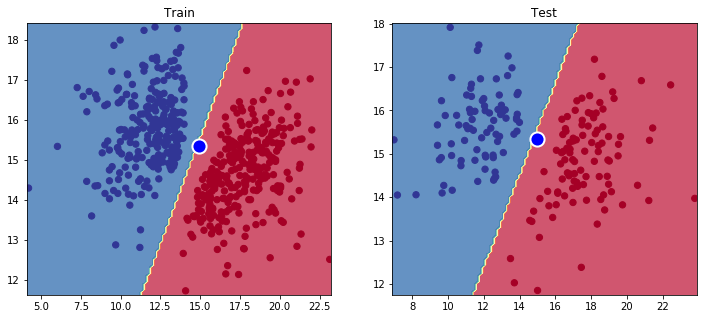

In [31]:
# Visualize the decision boundary
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title("Train")
plot_multiclass_decision_boundary(model=model, X=X_train, y=y_train)
plt.scatter(np.mean(df.leukocyte_count), np.mean(df.blood_pressure), s=200,
            c='b', edgecolor='w', linewidth=2)

plt.subplot(1,2,2)
plt.title("Test")
plot_multiclass_decision_boundary(model=model, X=X_test, y=y_test)
plt.scatter(np.mean(df.leukocyte_count), np.mean(df.blood_pressure), s=200,
            c='b', edgecolors='w', linewidths=2)
plt.show()